# 📥 Imports 

In [177]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

# set and sns matplotlib defaults
#select seaborn color pallete
sns.set_palette('plasma')
pal = sns.set_palette('plasma')
print(sns.color_palette().as_hex())

['#5302a3', '#8b0aa5', '#b83289', '#db5c68', '#f48849', '#febd2a']


# **Project Scenario**
## Answer at least 5 of the 7 questions below and submit email with answers and an executive summary in the form of a slide.

Hello,

I have some questions for you that I need to be answered before the board meeting Friday afternoon. I need to be able to speak to the following questions. I also need a single slide that I can incorporate into my existing presentation (Google Slides) that summarizes the most important points. My questions are listed below; however, if you discover anything else important that I didn’t think to ask, please include that as well.


1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?
8. Anything else I should be aware of?

# **Project Goals**
### Answer the following questions using anomoly detection techniques.
1.  Which lesson appears to attract the most traffic consistently across cohorts (per program)?
1.  Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
1.  Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

1. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
1. Which lessons are least accessed?

# 📥 Acquire

In [178]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [179]:
url = get_db_url("curriculum_logs")

sql_query = """
SELECT l.date, l.time, l.path, l.user_id, l.ip, c.name as cohort_name, c.start_date, c.end_date, c.program_id
FROM logs as l
JOIN cohorts as c ON l.cohort_id = c.id
ORDER BY c.name;

"""


df = pd.read_sql(sql_query, url)
#df.date = pd.to_datetime(df.date)
df = df.set_index(pd.to_datetime(df.date + ' ' + df.time))

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847330 entries, 2021-04-05 17:05:24 to 2021-01-25 00:36:01
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         847330 non-null  object
 1   time         847330 non-null  object
 2   path         847329 non-null  object
 3   user_id      847330 non-null  int64 
 4   ip           847330 non-null  object
 5   cohort_name  847330 non-null  object
 6   start_date   847330 non-null  object
 7   end_date     847330 non-null  object
 8   program_id   847330 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 64.6+ MB


# 🧹 Data Prep

In [181]:
df.shape

(847330, 9)

In [182]:
# remove path nulls
df = df[df.path.isna() == False]

In [183]:
df.shape

(847329, 9)

In [184]:
# remove images from paths along with home page (/) and search
df = df[~df.path.str.endswith('jpg')]
df = df[~df.path.str.endswith('jpeg')]
df = df[~df.path.str.endswith('svg')]
df = df[~df.path.str.endswith('jpg')]
df = df[(df.path != '/') & (df.path != 'search/search_index.json')]

In [185]:
df.shape

(765906, 9)

In [186]:
#subset df into webdev and ds dfs and remove staff
ds = df[df.program_id.isin([3])]
#remove staff
ds = ds[ds.cohort_name != 'Staff']
wd = df[df.program_id.isin([1, 2, 4])]
#remove staff
wd = wd[wd.cohort_name != 'Staff']

# 📊 Initial Overview Exploration

# Webdev Probability Plots

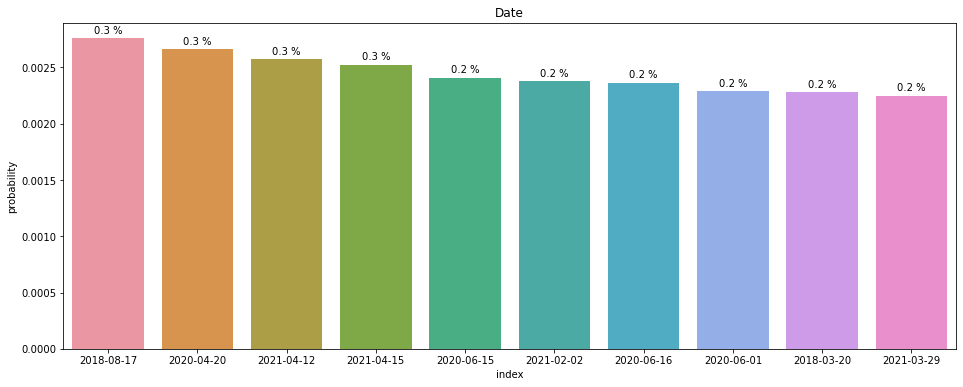

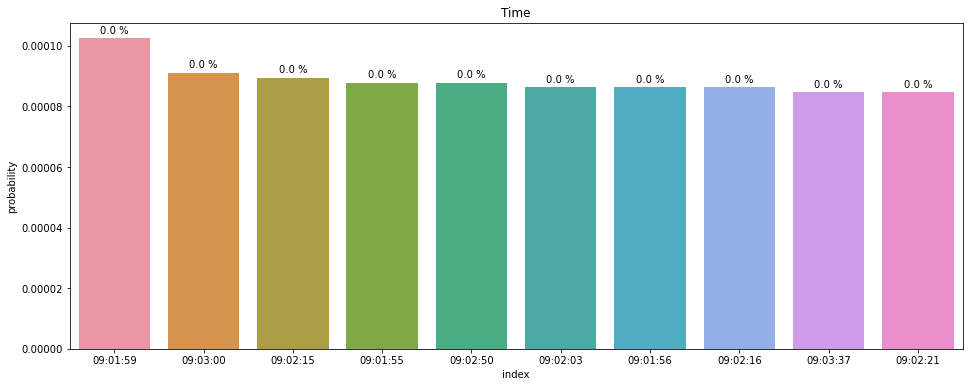

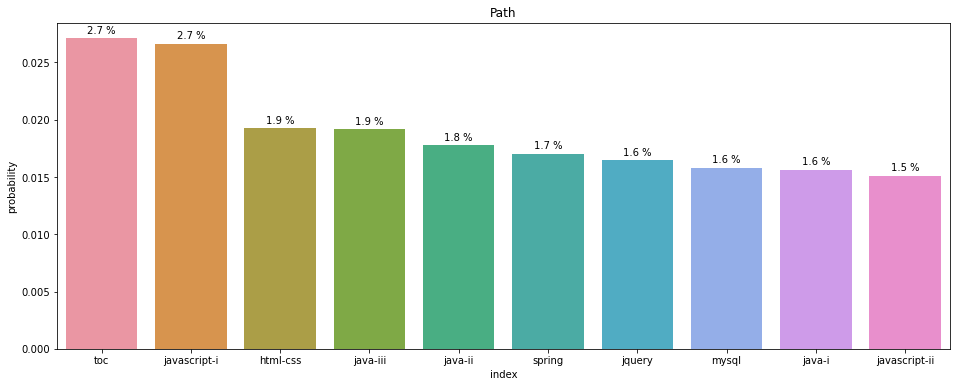

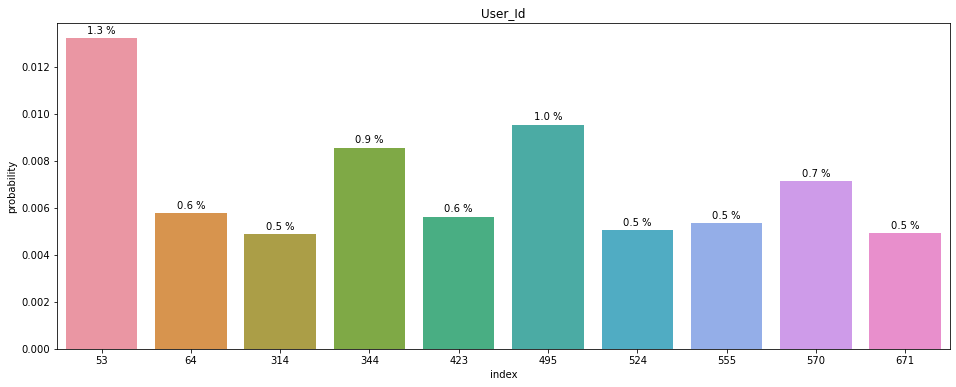

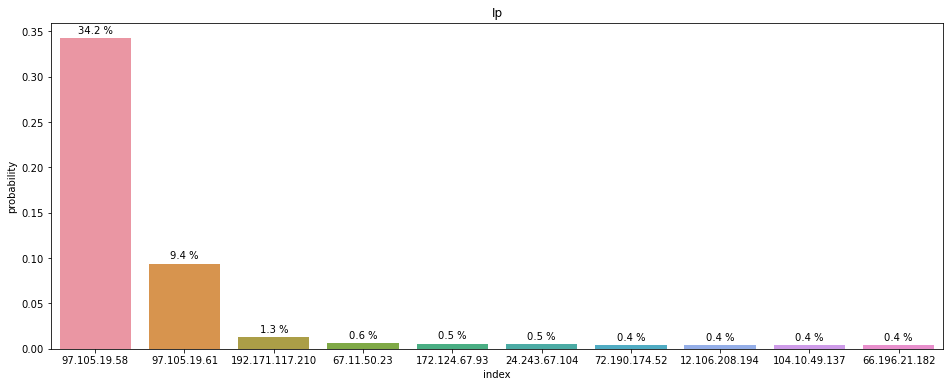

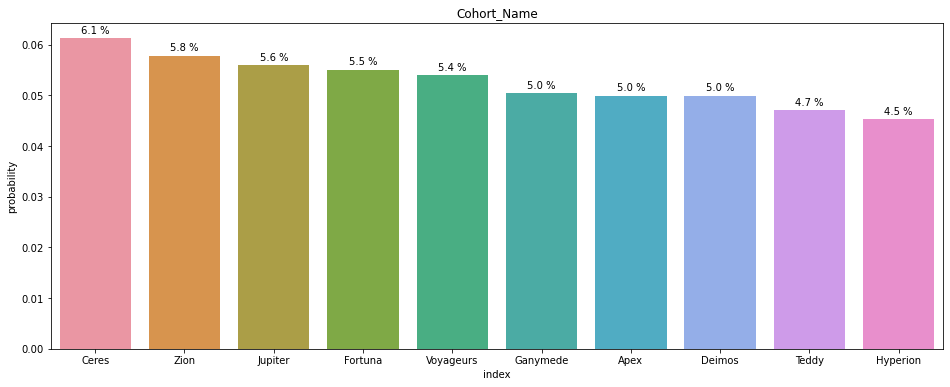

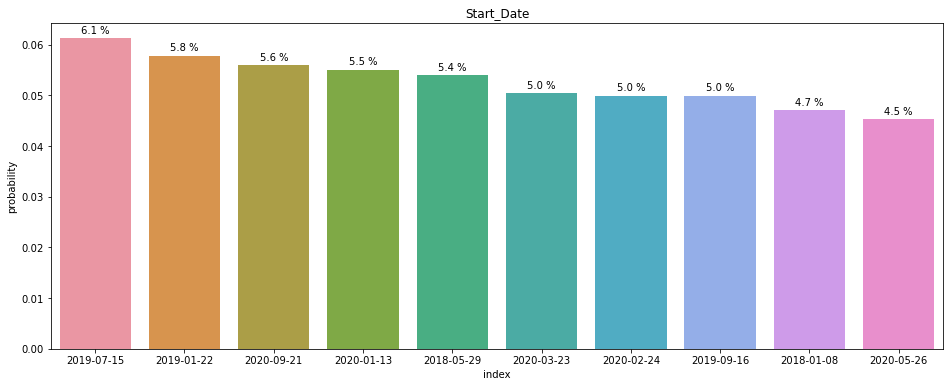

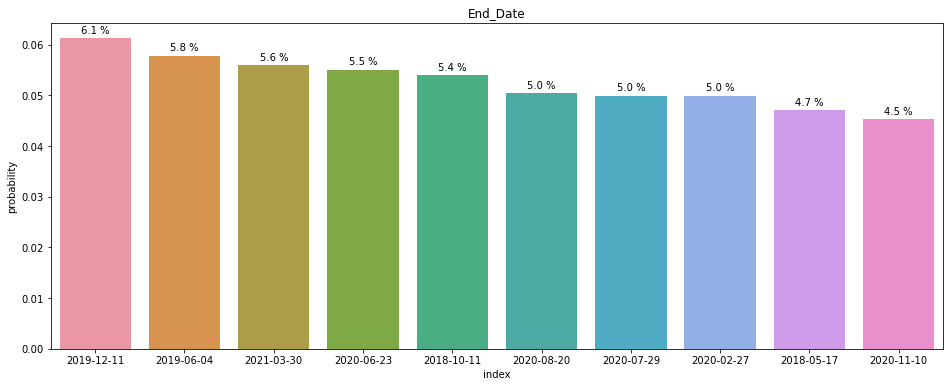

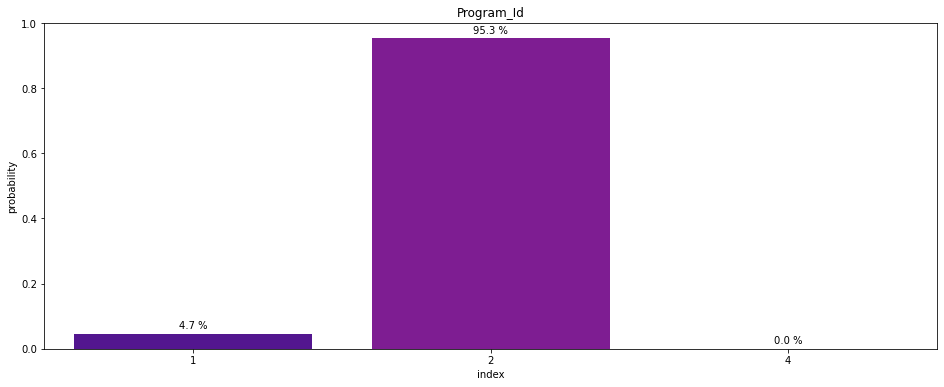

In [187]:
for col in wd.columns:
    plt.figure(figsize=(16, 6))
    splot = sns.barplot(x='index', y=col, data=wd[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

# Data Science Probability Plots

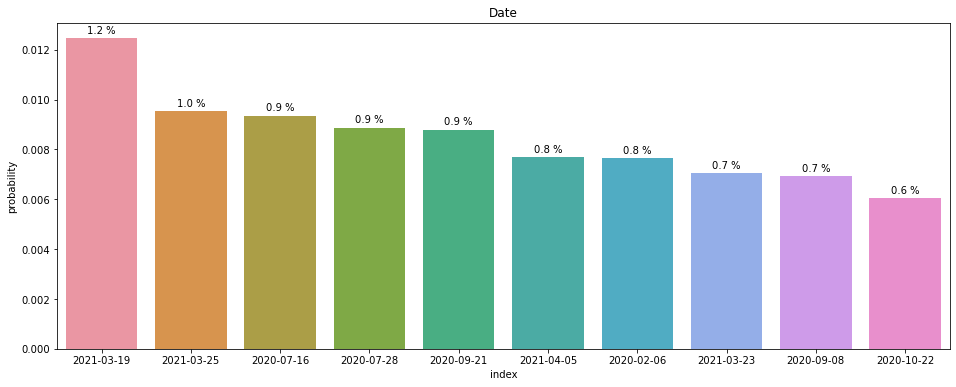

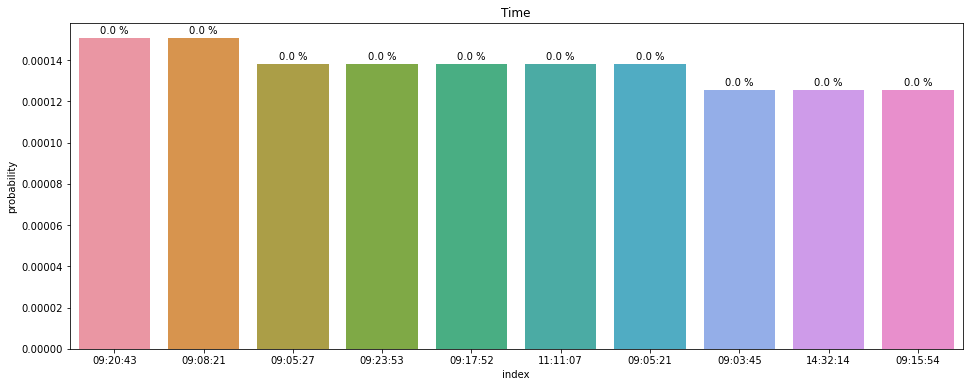

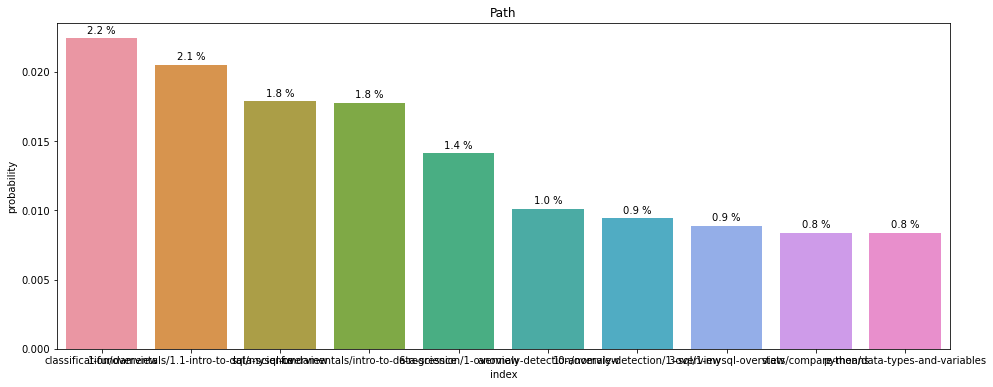

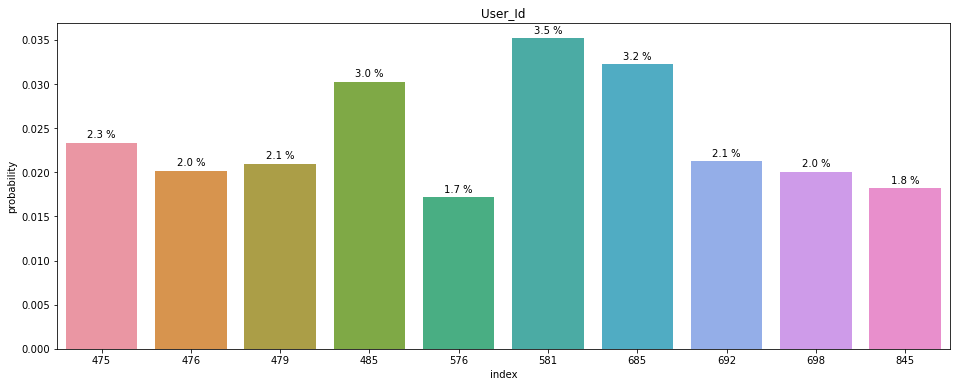

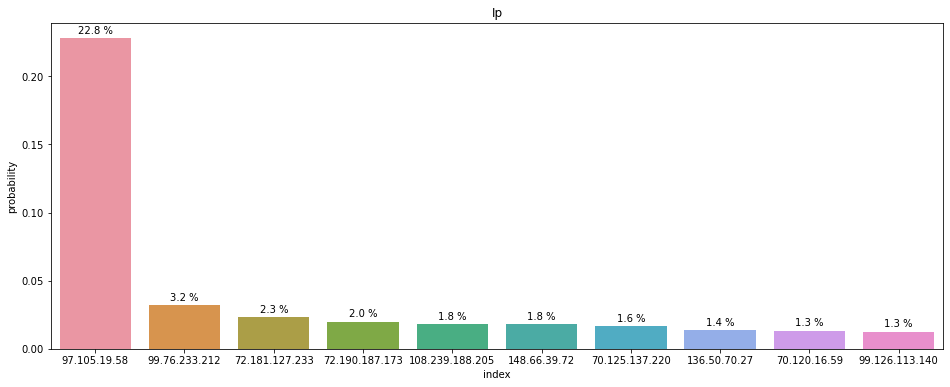

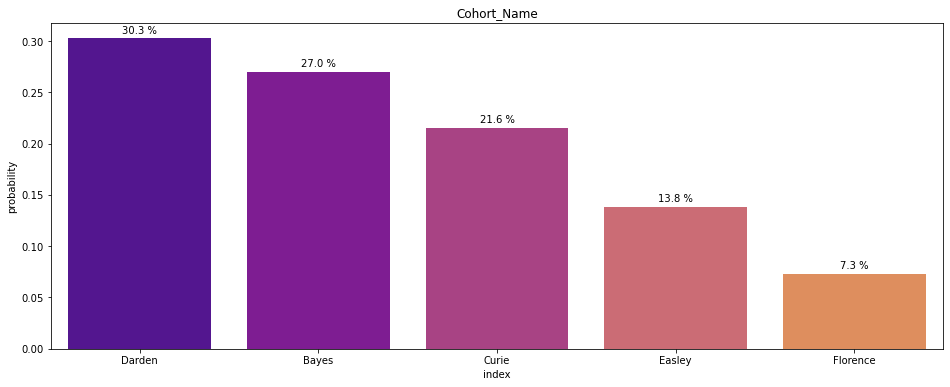

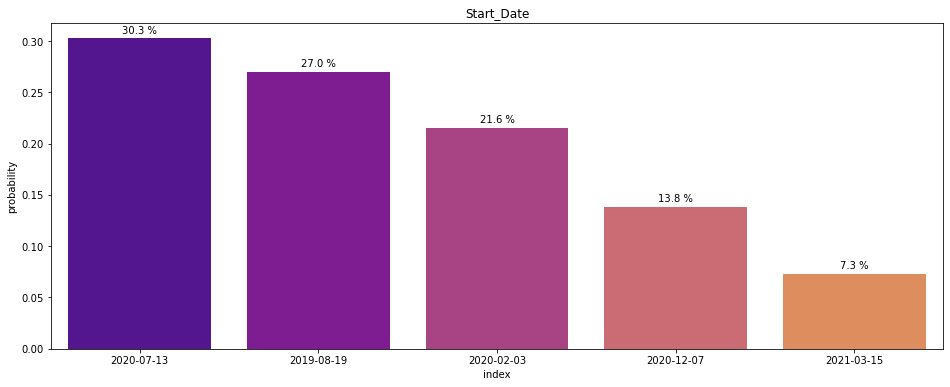

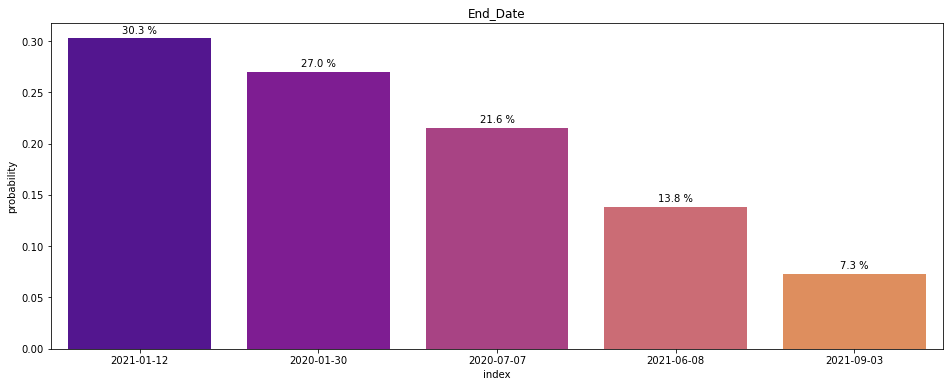

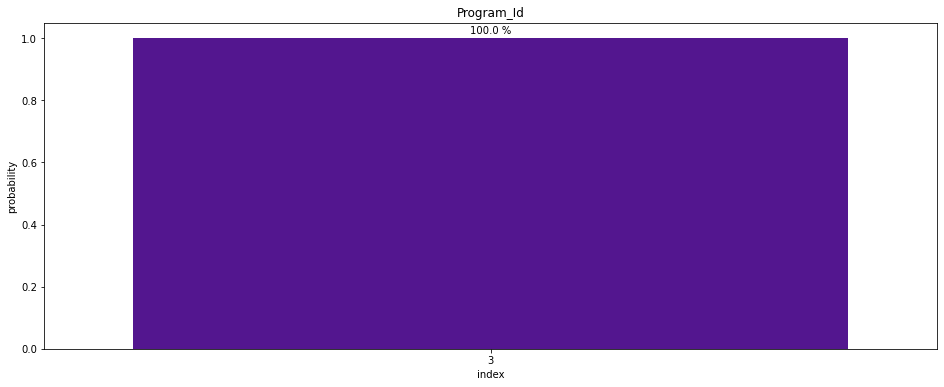

In [188]:
for col in ds.columns:
    plt.figure(figsize=(16, 6))
    splot = sns.barplot(x='index', y=col, data=ds[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

## 🕵🏻‍♀️ Which lesson appears to attract the most traffic consistently across cohorts (per program)?

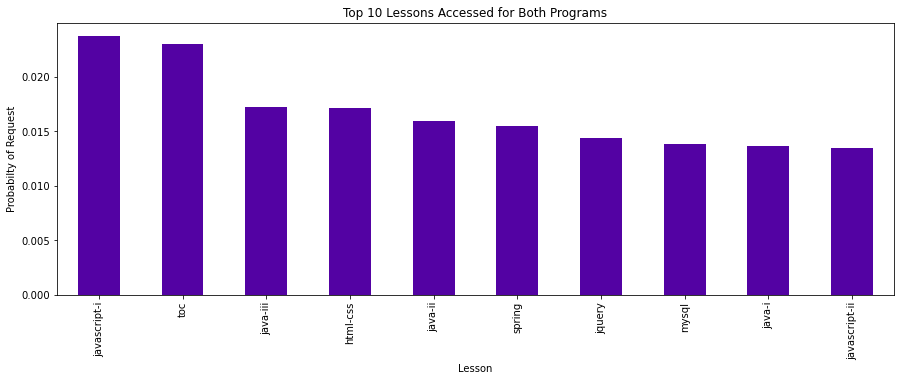

In [189]:
#lets look at lessons across both programs first visually
df['path'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Both Programs')
plt.xlabel('Lesson')
plt.ylabel('Probabilty of Request');

In [190]:
ds.groupby('cohort_name').path.value_counts(normalize=True)

cohort_name  path                                    
Bayes        1-fundamentals/1.1-intro-to-data-science    0.029777
             6-regression/1-overview                     0.024240
             10-anomaly-detection/1-overview             0.017866
             6-regression/5.0-evaluate                   0.015493
             5-stats/3-probability-distributions         0.014889
                                                           ...   
Florence     stats/simulation                            0.000172
             storytelling/creating-charts                0.000172
             storytelling/overview                       0.000172
             timeseries/modeling-lesson2                 0.000172
             where                                       0.000172
Name: path, Length: 1612, dtype: float64

In [191]:
#function to view value counts and probability
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

## Data Science Top Lessons

In [192]:
#create df to look at lesson probability and counts
path_ds = value_counts_and_frequencies(ds.path)

In [193]:
path_ds.head(20)

,count,proba
classification/overview,1785,0.022421
1-fundamentals/1.1-intro-to-data-science,1633,0.020512
sql/mysql-overview,1424,0.017887
fundamentals/intro-to-data-science,1413,0.017748
6-regression/1-overview,1124,0.014118
anomaly-detection/overview,804,0.010099
10-anomaly-detection/1-overview,751,0.009433
3-sql/1-mysql-overview,707,0.008880
stats/compare-means,668,0.008391
python/data-types-and-variables,667,0.008378


<AxesSubplot:>

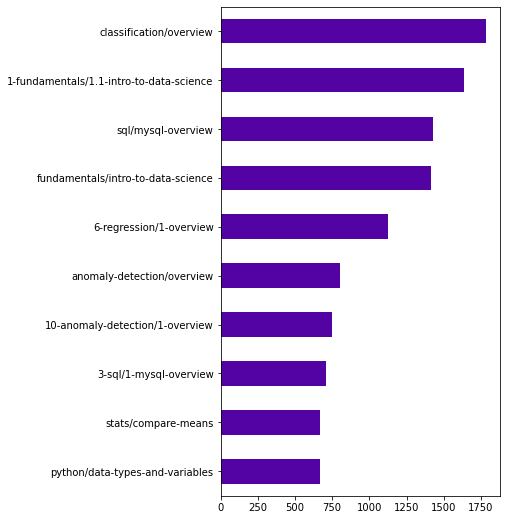

In [194]:
#visualize
path_ds['count'].sort_values().tail(10).plot.barh(figsize=(5, 9))

## Webdev Top Lessons

In [195]:
path_wd = value_counts_and_frequencies(wd.path)

In [196]:
path_wd['count'].sort_values().tail(20)

java-iii/jsp-and-jstl                                                         6121
html-css/css-ii/bootstrap-grid-system                                         6140
javascript-i/loops                                                            6168
mysql/databases                                                               6321
html-css/elements                                                             6404
mysql/tables                                                                  6692
javascript-i/javascript-with-html                                             6739
appendix                                                                      6769
javascript-i/functions                                                        6799
javascript-i/introduction/working-with-data-types-operators-and-variables     7041
javascript-ii                                                                 9297
java-i                                                                        9605
mysq

<AxesSubplot:>

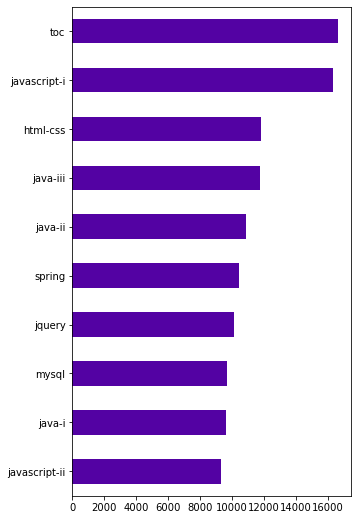

In [197]:
path_wd['count'].sort_values().tail(10).plot.barh(figsize=(5, 9))

## Question One Takeaways:
- The lesson with the most student traffic accross all cohorts for data science was the classification overview lesson.
- The lesson with the most student traffice accross all cohorts for web development was the Javascript-i lesson.

# 🕵🏻‍♀️ Question Two: Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [198]:
#lets look at cohort value counts
df.cohort_name.value_counts()

Staff         71742
Ceres         37679
Zion          35539
Jupiter       34415
Fortuna       33844
Voyageurs     33198
Ganymede      31022
Apex          30725
Deimos        30672
Teddy         28971
Hyperion      27820
Betelgeuse    27621
Ulysses       26745
Xanadu        26248
Europa        25996
Darden        24100
Wrangell      23948
Andromeda     23860
Kalypso       22285
Bayes         21493
Yosemite      19401
Curie         17166
Bash          16281
Luna          15727
Marco         15457
Easley        11024
Lassen         9425
Arches         8217
Sequoia        6758
Neptune        6727
Florence       5830
Olympic        4684
Kings          2620
Pinnacles      2000
Oberon         1532
Hampton        1487
Quincy         1073
Niagara         711
Mammoth         657
Glacier         529
Joshua          294
Ike             233
Badlands         76
Franklin         67
Apollo            4
Denali            3
Name: cohort_name, dtype: int64

## Data Science Cohort Lesson Access Anomolies

In [199]:
#Data Science Group by path and look at value counts for each lesson
ds_cohort = ds.groupby('path').cohort_name.value_counts().sort_values().unstack(0)
ds_cohort = ds_cohort.dropna(axis=1)
ds_cohort.head(25)

path,1-fundamentals/1.1-intro-to-data-science,advanced-topics/cross-validation,anomaly-detection/overview,appendix/coding-challenges,appendix/coding-challenges/amateur,appendix/data-viz-references,appendix/data_science_community,appendix/documentation,appendix/ds-environment-setup,appendix/git-teamwork,...,stats/overview,stats/probability-distributions,stats/simulation,storytelling/connecting-to-data,storytelling/create,storytelling/creating-charts,storytelling/overview,storytelling/tableau,storytelling/understand,timeseries/overview
cohort_name,,,,,,,,,,,,,,,,,,,,,
Bayes,640.0,1.0,15.0,1.0,1.0,15.0,2.0,9.0,36.0,2.0,...,7.0,12.0,13.0,2.0,2.0,5.0,2.0,1.0,3.0,3.0
Curie,461.0,5.0,72.0,3.0,3.0,16.0,1.0,28.0,57.0,3.0,...,17.0,19.0,15.0,3.0,1.0,2.0,2.0,1.0,1.0,10.0
Darden,460.0,41.0,592.0,13.0,14.0,14.0,55.0,26.0,22.0,13.0,...,133.0,269.0,215.0,47.0,139.0,36.0,88.0,47.0,117.0,92.0
Easley,8.0,3.0,106.0,2.0,4.0,9.0,30.0,8.0,7.0,5.0,...,95.0,125.0,127.0,49.0,155.0,35.0,76.0,69.0,102.0,63.0
Florence,64.0,1.0,19.0,9.0,13.0,3.0,29.0,7.0,6.0,3.0,...,2.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,4.0,5.0


In [200]:
#Group by path and look at probability for each lesson
ds_cohort = ds.groupby('path').cohort_name.value_counts(normalize=True).sort_values().unstack(0)
ds_cohort = ds_cohort.dropna(axis=1)
ds_cohort.head(25)

path,1-fundamentals/1.1-intro-to-data-science,advanced-topics/cross-validation,anomaly-detection/overview,appendix/coding-challenges,appendix/coding-challenges/amateur,appendix/data-viz-references,appendix/data_science_community,appendix/documentation,appendix/ds-environment-setup,appendix/git-teamwork,...,stats/overview,stats/probability-distributions,stats/simulation,storytelling/connecting-to-data,storytelling/create,storytelling/creating-charts,storytelling/overview,storytelling/tableau,storytelling/understand,timeseries/overview
cohort_name,,,,,,,,,,,,,,,,,,,,,
Bayes,0.391917,0.019608,0.018657,0.035714,0.028571,0.263158,0.017094,0.115385,0.281250,0.076923,...,0.027559,0.028169,0.035040,0.019417,0.006689,0.063291,0.011834,0.008197,0.013216,0.017341
Curie,0.282303,0.098039,0.089552,0.107143,0.085714,0.280702,0.008547,0.358974,0.445312,0.115385,...,0.066929,0.044601,0.040431,0.029126,0.003344,0.025316,0.011834,0.008197,0.004405,0.057803
Darden,0.281690,0.803922,0.736318,0.464286,0.400000,0.245614,0.470085,0.333333,0.171875,0.500000,...,0.523622,0.631455,0.579515,0.456311,0.464883,0.455696,0.520710,0.385246,0.515419,0.531792
Easley,0.004899,0.058824,0.131841,0.071429,0.114286,0.157895,0.256410,0.102564,0.054688,0.192308,...,0.374016,0.293427,0.342318,0.475728,0.518395,0.443038,0.449704,0.565574,0.449339,0.364162
Florence,0.039192,0.019608,0.023632,0.321429,0.371429,0.052632,0.247863,0.089744,0.046875,0.115385,...,0.007874,0.002347,0.002695,0.019417,0.006689,0.012658,0.005917,0.032787,0.017621,0.028902


## DS Takeaways:
- Data Science: The intro to Data Science lesson was acessed frequently by all cohorts except Easley.  They only accessed it 8 times.

## Webdev Cohort Lesson Access Anomolies

In [201]:
#look at paths by cohort for webdev
wd_cohort = wd.groupby('path').cohort_name.value_counts().sort_values().unstack(0)
wd_cohort.head(25)

path,.git,.gitignore,.well-known/assetlinks.json,00_index,01_intro,02_listing_files,03_file_paths,04_navigating_the_filesystem,05_creating_files_and_directories,0_Classification_Algorithms,...,web-design/ui/color,web-design/ui/typography,web-design/ui/visuals,web-design/ux,web-design/ux/layout,web-design/ux/layout/.json,web-design/ux/purpose,web-dev-day-two,wp-admin,wp-login
cohort_name,,,,,,,,,,,,,,,,,,,,,
Andromeda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,9.0,11.0,NaN,6.0,NaN,8.0,NaN,NaN,NaN
Apex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,21.0,20.0,NaN,18.0,NaN,23.0,NaN,NaN,NaN
Apollo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Badlands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.0,5.0,NaN,3.0,NaN,3.0,2.0,NaN,NaN
Betelgeuse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.0,28.0,30.0,NaN,38.0,NaN,32.0,NaN,NaN,NaN
Ceres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.0,33.0,34.0,NaN,34.0,1.0,28.0,NaN,NaN,NaN
Deimos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,18.0,16.0,NaN,19.0,NaN,14.0,NaN,NaN,NaN


In [202]:
# use count and probability function to look at WD, because dropping nulls removes all columns
wd_cohort = value_counts_and_frequencies(wd.groupby('cohort_name').path)
wd_cohort.head()

count     proba
cohort_name path                         
Andromeda   toc             638  0.026739
            javascript-i    516  0.021626
            spring          487  0.020411
            java-iii        433  0.018148
            java-ii         398  0.016681

In [203]:
#ds_cohorts1 = ds_cohorts1[ds_cohorts1['count'] > 1]

In [204]:
wd_cohort.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10265 entries, ('Andromeda', 'toc') to ('Zion', 'web-design/ux/purpose')
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   10265 non-null  int64  
 1   proba   10265 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 234.1+ KB


In [205]:
wd_cohort.head()

count     proba
cohort_name path                         
Andromeda   toc             638  0.026739
            javascript-i    516  0.021626
            spring          487  0.020411
            java-iii        433  0.018148
            java-ii         398  0.016681

In [206]:
wd_cohort['count'].sort_values().tail(50)

cohort_name  path                    
Ganymede     java-iii                     651
Fortuna      java-ii                      657
Voyageurs    mysql                        663
Apex         java-iii                     663
             java-ii                      666
             javascript-i                 669
Zion         spring                       672
             html-css                     675
Luna         javascript-i                 676
Ceres        java-ii                      681
             java-iii                     682
Hyperion     java-ii                      688
Yosemite     toc                          697
Hyperion     java-iii                     701
Betelgeuse   javascript-i                 717
Ulysses      mkdocs/search_index.json     721
Xanadu       javascript-i                 722
Teddy        java-iii                     732
Apex         html-css                     738
Teddy        spring                       744
Deimos       toc                          

In [207]:
wd_cohort['count'].sort_values().head(50)

cohort_name  path                                                  
Zion         web-design/ux/purpose                                     1
Deimos       slides/sessions_and_cookies                               1
             syntax-types-and-variables                                1
Denali       mkdocs/search_index.json                                  1
             prework/databases                                         1
             prework/versioning/github                                 1
Olympic      content/mysql/sequel-pro/gitbook/images/favicon.ico       1
             content/mysql/intro-to-mysql/tables.html                  1
             content/mysql/clauses                                     1
Deimos       slides/object_oriented_programming                        1
Olympic      content/mysql/basic-statements/update.html                1
             content/mysql/basic-statements/delete.html                1
             content/laravel/quickstart/seeders.html    

<AxesSubplot:ylabel='cohort_name,path'>

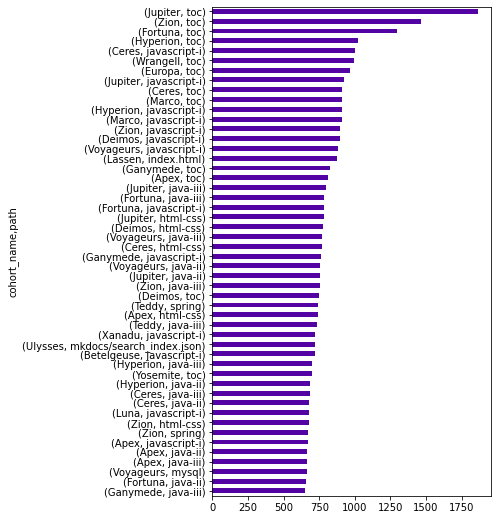

In [208]:
wd_cohort['count'].sort_values().tail(50).plot.barh(figsize=(5, 9))

<AxesSubplot:ylabel='cohort_name,path'>

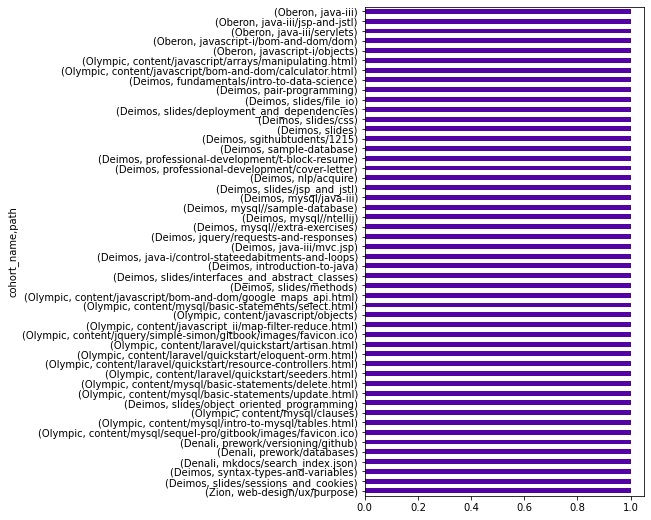

In [209]:
wd_cohort['count'].sort_values().head(50).plot.barh(figsize=(5, 9))

<AxesSubplot:ylabel='cohort_name,path'>

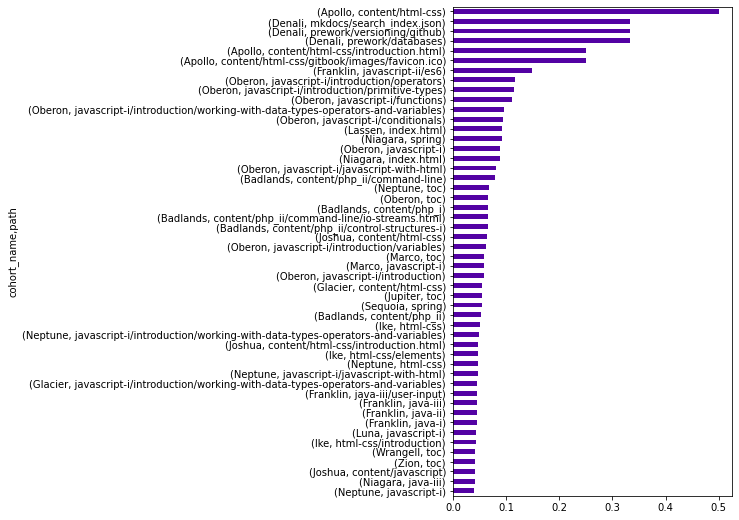

In [210]:
#look at high probability paths
wd_cohort['proba'].sort_values().tail(50).plot.barh(figsize=(5, 9))

<AxesSubplot:ylabel='cohort_name,path'>

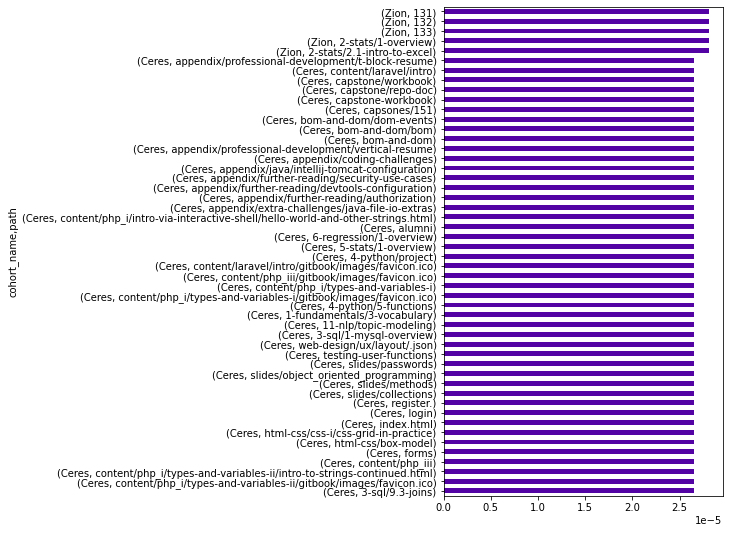

In [211]:
#look at lower probabiliy paths
wd_cohort['proba'].sort_values().head(50).plot.barh(figsize=(5, 9))

## Question Two takeaways:
- Data Science: The intro to Data Science lesson was acessed frequently by all cohorts except Easley.  They only accessed it 8 times.
- Oberon cohort accessed the Java iii lessons significantly less than any other webdev cohort.


# 🕵🏻‍♀️ Question Seven: Which lessons are least accessed?
- answering this early because it deals with paths.

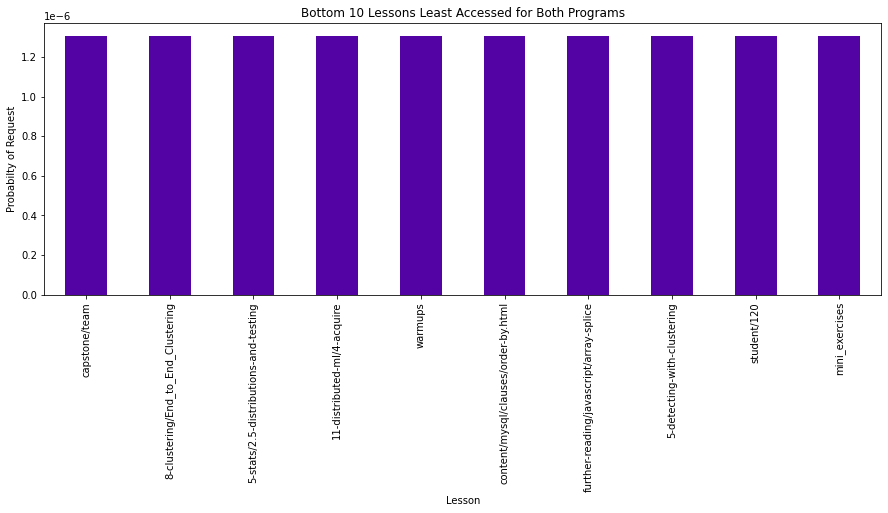

In [212]:
#lets look at lessons across both programs first visually
df['path'].value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
plt.title('Bottom 10 Lessons Least Accessed for Both Programs')
plt.xlabel('Lesson')
plt.ylabel('Probabilty of Request');

In [213]:
path_df = value_counts_and_frequencies(df.path)

In [214]:
path_df = path_df[path_df['count'] > 1]

<AxesSubplot:>

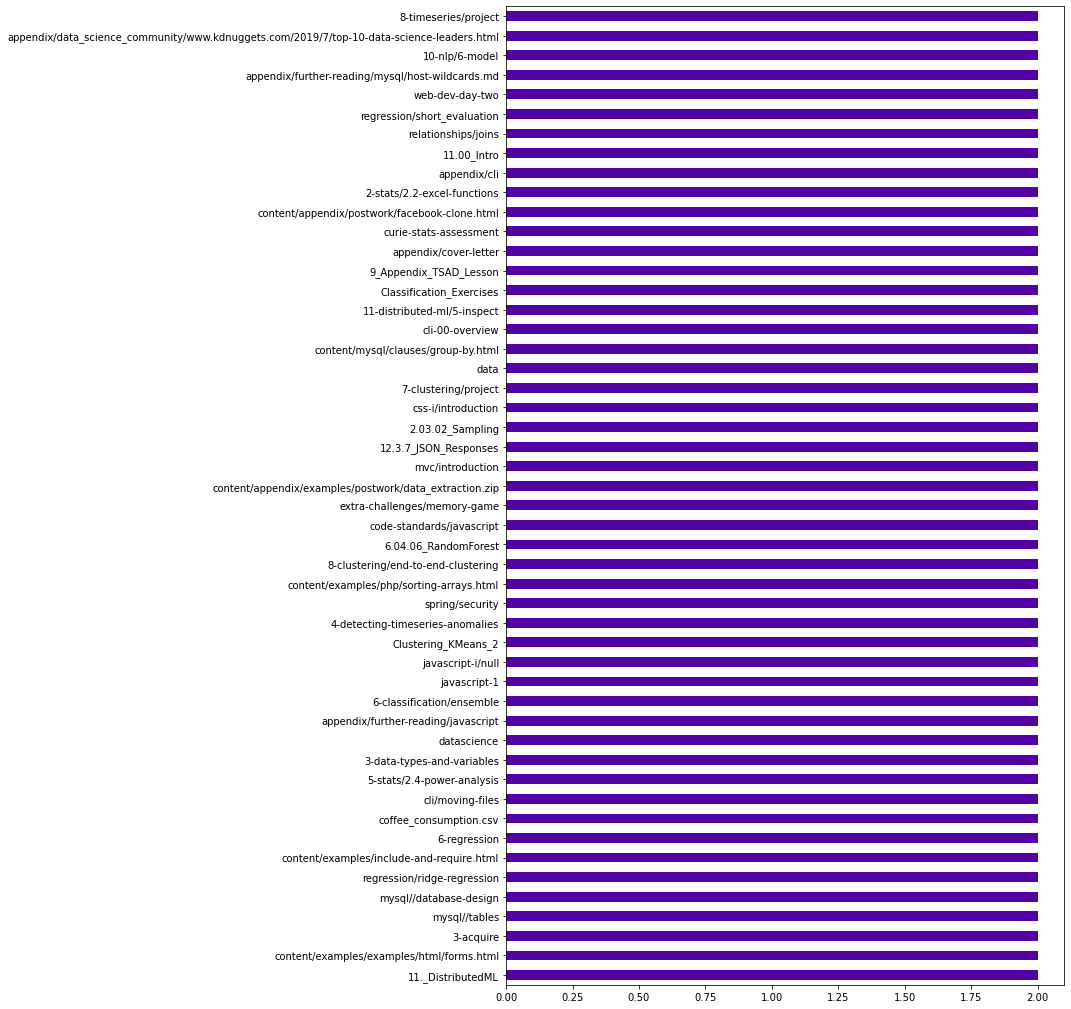

In [215]:
path_df['count'].sort_values().head(50).plot.barh(figsize=(10, 18))

In [216]:
path_df.tail(50)

,count,proba
split-and-scale,2,0.000003
subqueries,2,0.000003
5.04.03_RidgeRegression,2,0.000003
7-classification/svm,2,0.000003
4_panda_bears,2,0.000003
slides/design_patterns,2,0.000003
capstones,2,0.000003
content/mysql/aliases-and-functions/aliases.html,2,0.000003
content/primitive-types.html,2,0.000003
content/examples/javascript/gitbook/images/favicon.ico,2,0.000003


In [217]:
df['path'].value_counts(normalize=True).tail(50)

strudents                                                        0.000001
students/468/notes                                               0.000001
professional-development/professional-resume                     0.000001
console-io                                                       0.000001
5-stats/4.2-compare-means/null                                   0.000001
appendix/css-practice                                            0.000001
Dataset_Challenge                                                0.000001
appendix/spring/authorization                                    0.000001
hfdgafdja                                                        0.000001
html-css/css-i/positioning/specimen/MaterialIcons-Regular.ttf    0.000001
wp-admin                                                         0.000001
examples/bootstrap/pizza.pn                                      0.000001
content/appendix/javascript/functions/templating.html            0.000001
npm                                   

## Least accessed by Data Science Students

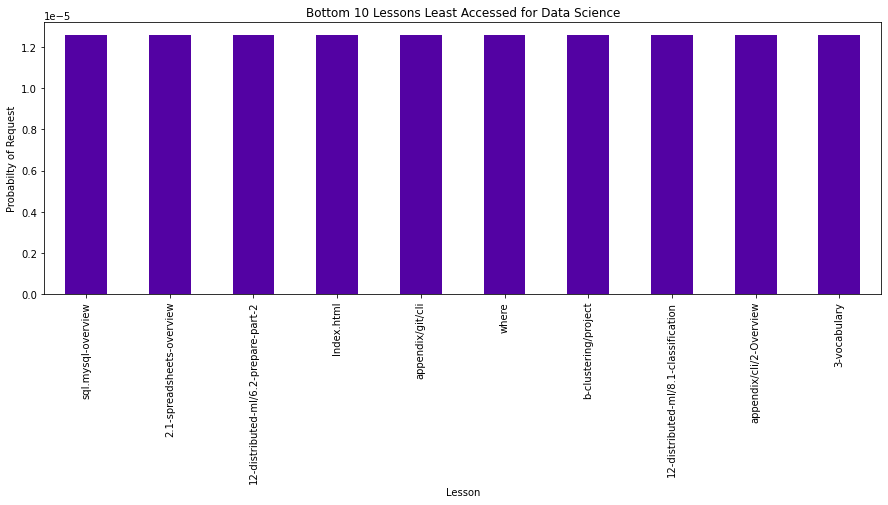

In [218]:
#lets look at lessons across data science visually
ds['path'].value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
plt.title('Bottom 10 Lessons Least Accessed for Data Science')
plt.xlabel('Lesson')
plt.ylabel('Probabilty of Request');

In [221]:
least_ds = ds['path'].value_counts(normalize=True)
least_ds.tail()

where                                   0.000013
b-clustering/project                    0.000013
12-distributed-ml/8.1-classification    0.000013
appendix/cli/2-Overview                 0.000013
3-vocabulary                            0.000013
Name: path, dtype: float64

### Lessons Least Accessed by Webdev Students

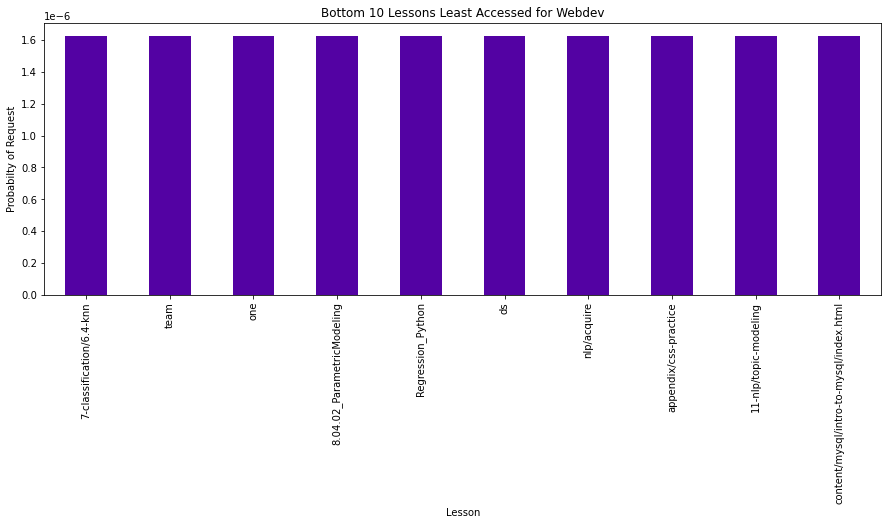

In [223]:
#lets look at lessons for webdev visually
wd['path'].value_counts(normalize=True).tail(10).plot.bar(figsize=(15,5))
plt.title('Bottom 10 Lessons Least Accessed for Webdev')
plt.xlabel('Lesson')
plt.ylabel('Probabilty of Request');

## Question Two Takeaways:
- There were four statistics lessons that were least accessed and two clustering lessons.  These were the modules/topics with multiple lessons least accessed.
- Most of the least accessed lessons were Data Science topics, because there are less data science students vs webdev.
    - When broken down by program, the least accessed lessons for webdev were data science lessons.
    - Data Science students accessed two sql lessons and two machine learning overview lessons.

# 🕵🏻‍♀️ Question Three: Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [ ]:
df.shape

In [ ]:
# take subset to only include active students
active = df[(df.index > df.start_date) & (df.index < df.end_date)]
active.shape

In [ ]:
active.head()

In [ ]:
# create list of the 10 least active students
least_active = active.user_id.value_counts().tail(10).index.tolist()
least_active

In [ ]:
#Look at these students more closely by subsetting df by list above
active[active.user_id.isin(least_active)]

In [ ]:
#Visualize
active.user_id.value_counts().tail(10).plot.bar(figsize=(12,7))
plt.title('10 Least Active Students')
plt.xlabel('User')
plt.ylabel('Number of Requests')
plt.show()

## Question Three Takeaways:
Information about the least active students:
- All but one of the 10 least active students were webdev students.
- User 832 had the strangest activity of all the least active.  They only made two requests in the middle of when thier cohort was active.
- All other users seemed to drop out after the first day of the program

# 🕵🏻‍♀️ Question Six: What topics are grads continuing to reference after graduation and into their jobs (for each program)?

## Data Science Alumni Lesson Access

In [ ]:
#subset DS dataframe to users only active after graduation
alumni_ds = ds[(ds.index > ds.end_date)]
alumni_ds.head()

In [ ]:
alumni_ds.path.value_counts(normalize=True).head(20)

In [ ]:
# Visualize
alumni_ds.path.value_counts(normalize=True).head(10).plot.barh(figsize=(10,5))
plt.title('Top 10 Lessons Accessed by Data Science Alumni', fontsize=15)
plt.ylabel('Lesson', fontsize=15)
plt.xlabel('Probability of Requests', fontsize=15)
plt.show()

## Webdev Alumni Lesson Access

In [ ]:
#subset WD dataframe to users only active after graduation
alumni_wd = wd[(wd.index > wd.end_date)]
alumni_wd.head()

In [ ]:
alumni_wd.path.value_counts(normalize=True).head(20)

In [ ]:
# Visualize
alumni_wd.path.value_counts(normalize=True).head(10).plot.barh(figsize=(10,5))
plt.title('Top 10 Lessons Accessed by WebDev Alumni', fontsize=15)
plt.ylabel('Lesson', fontsize=15)
plt.xlabel('Probability of Requests', fontsize=15)
plt.show()

## Question 6 Takeaways:
- SQL lessons were accessed frequently accross both programs
- Webdev alumni accessed java, spring, and html lessons frequently.
- Webdev alumni also accessed the appendix frequently where data science students didn't.
- Data Science lessons most frequently accessed lesssons were from all different areas from modeling to anomoly detection.
- Database design, an appendix item for DS was also accessed frequently.

## With more time, I will address the remaining two questions in a later iteration of this project.